In [1]:
import scvelo as scv
import scanpy as sc, numpy as np, pandas as  pd, anndata as ad

In [2]:
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=150, frameon=False)

# Step 1: Load Data

In [3]:
adata = sc.read_h5ad('../data/processed/cells_postprocessed.h5ad')

In [4]:
# load loom files for spliced/unspliced matrices
ldata = scv.read('../data/processed/Pituitary_velocyto_all.loom', cache=True)
ldata.var_names_make_unique()

In [5]:
# merge matrices into the original adata object
adata = scv.utils.merge(adata, ldata)

In [6]:
# subsetting anndata object
hdata = adata[adata.obs.cell_type_brief.isin(['Som','Lac','Cort','Mel','Gonad','Thyro'])]

In [7]:
hdata = hdata[hdata.obs.treat.isin(['Saline','LPS','Poly(i:c)'])]

# Step 2-1: Pou1f1-dependent lineage
## Step 2-1-1: Recompute UMAP embedding

In [8]:
pou1f1_indep = hdata[hdata.obs.cell_type_brief.isin(['Cort','Gonad','Mel'])]

In [9]:
sc.pp.normalize_total(pou1f1_indep, target_sum=1e4)
sc.pp.log1p(pou1f1_indep)
sc.pp.highly_variable_genes(pou1f1_indep, min_mean=0.0125, max_mean=3, min_disp=0.5)
pou1f1_indep.raw = pou1f1_indep
pou1f1_indep = pou1f1_indep[:, pou1f1_indep.var.highly_variable]
sc.pp.regress_out(pou1f1_indep, ['nCount_RNA'])
sc.pp.scale(pou1f1_indep, max_value=10)

In [10]:
sc.tl.pca(pou1f1_indep, svd_solver='arpack')
sc.pp.neighbors(pou1f1_indep, n_neighbors=15, n_pcs=50)
sc.tl.umap(pou1f1_indep)

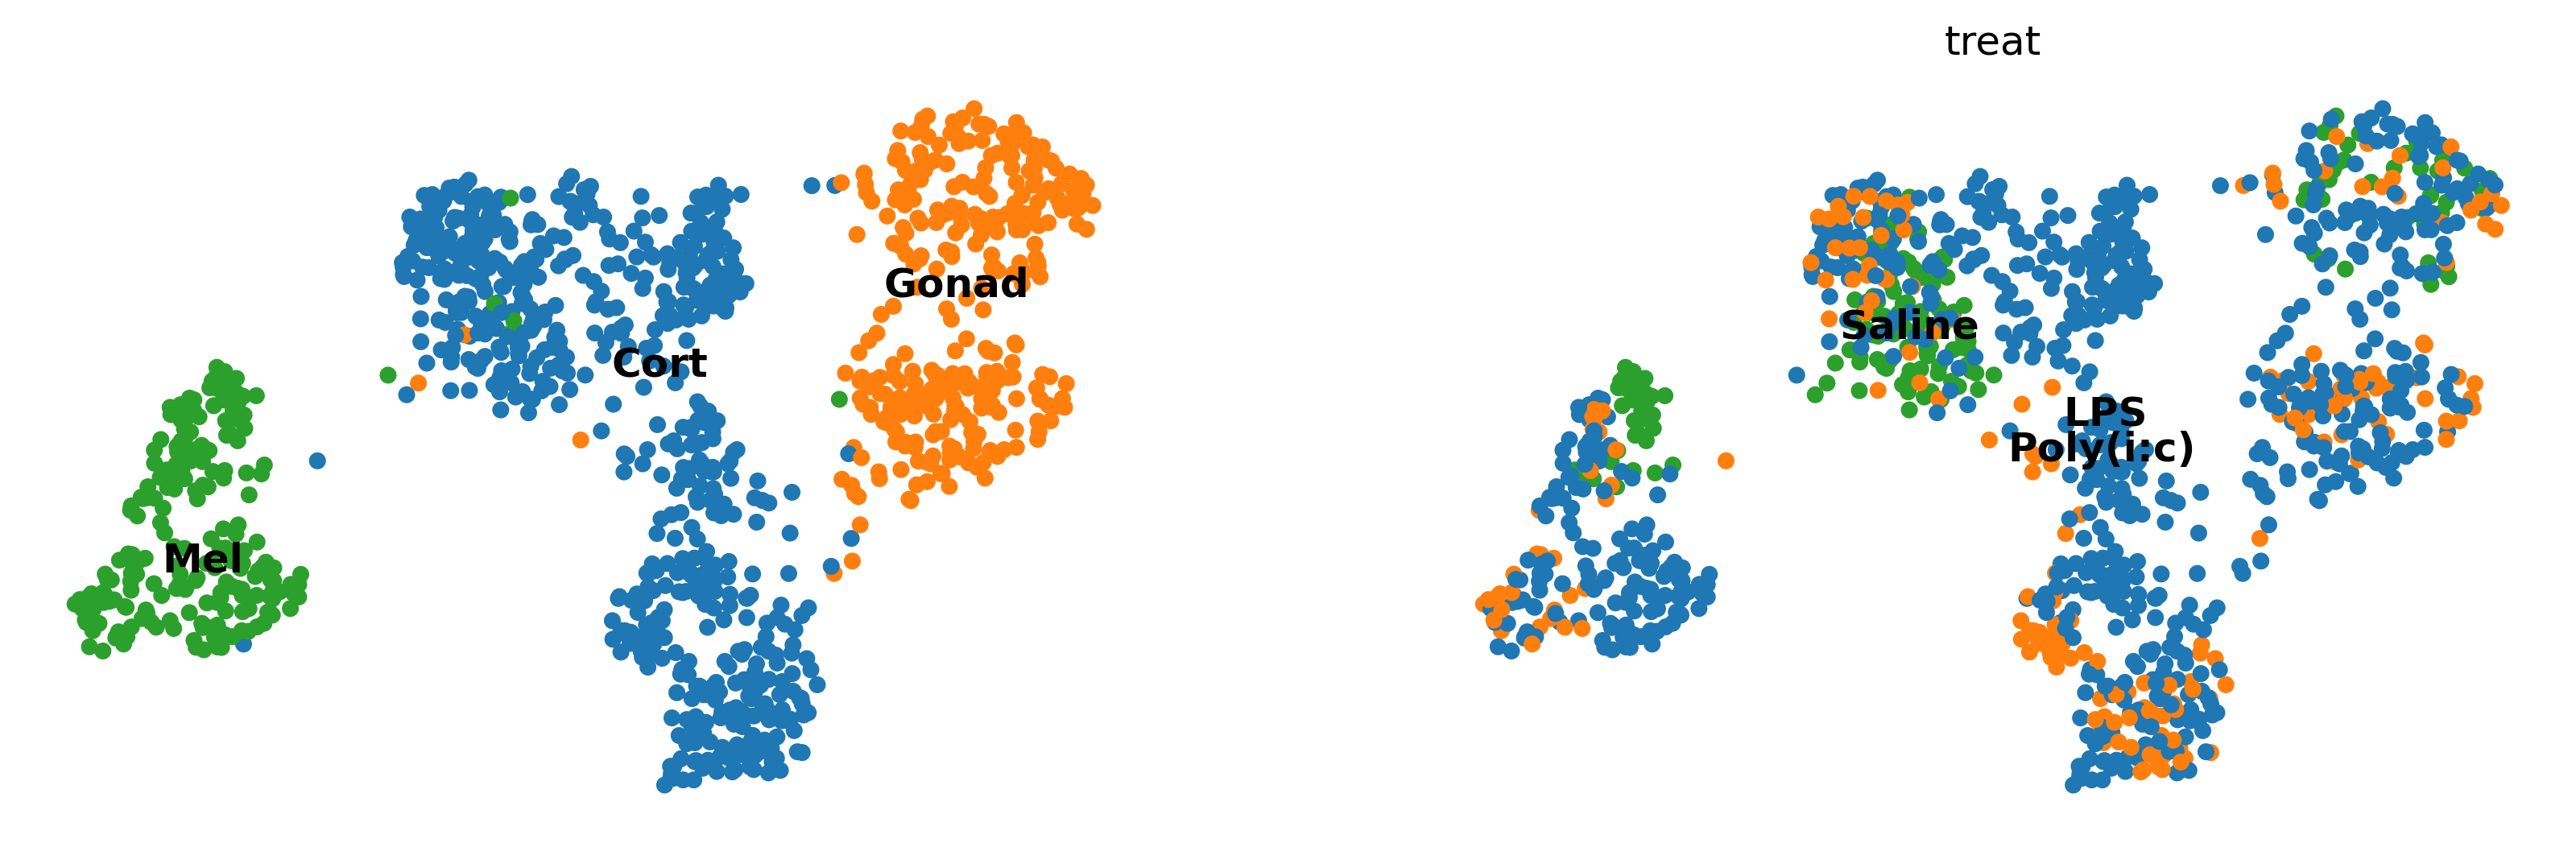

In [11]:
# plot umap to check
sc.pl.umap(pou1f1_indep, color=['cell_type_brief','treat'], frameon=False, legend_loc='on data', title='')

## Step 2-1-2: Computing RNA velocity using scvelo dymanic model

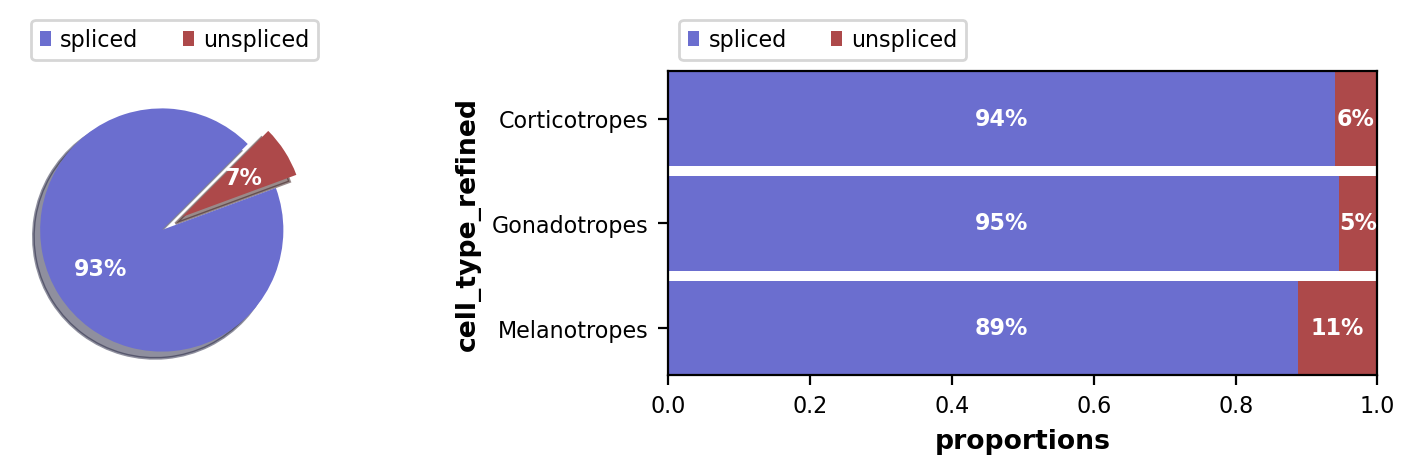

In [12]:
scv.pl.proportions(pou1f1_indep, groupby='cell_type_refined')

In [13]:
# pre-process
scv.pp.filter_and_normalize(pou1f1_indep)
scv.pp.moments(pou1f1_indep)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [14]:
sc.tl.leiden(pou1f1_indep)

In [15]:
scv.tl.recover_dynamics(pou1f1_indep, n_jobs=16)

recovering dynamics (using 16/48 cores)


  0%|          | 0/419 [00:00<?, ?gene/s]

    finished (0:00:09) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [16]:
# compute velocity using the dynamical model (Bergen., 2020), i.e. mode='dynamical'
scv.tl.velocity(pou1f1_indep, mode='dynamical')
scv.tl.velocity_graph(pou1f1_indep)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/48 cores)


  0%|          | 0/1178 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


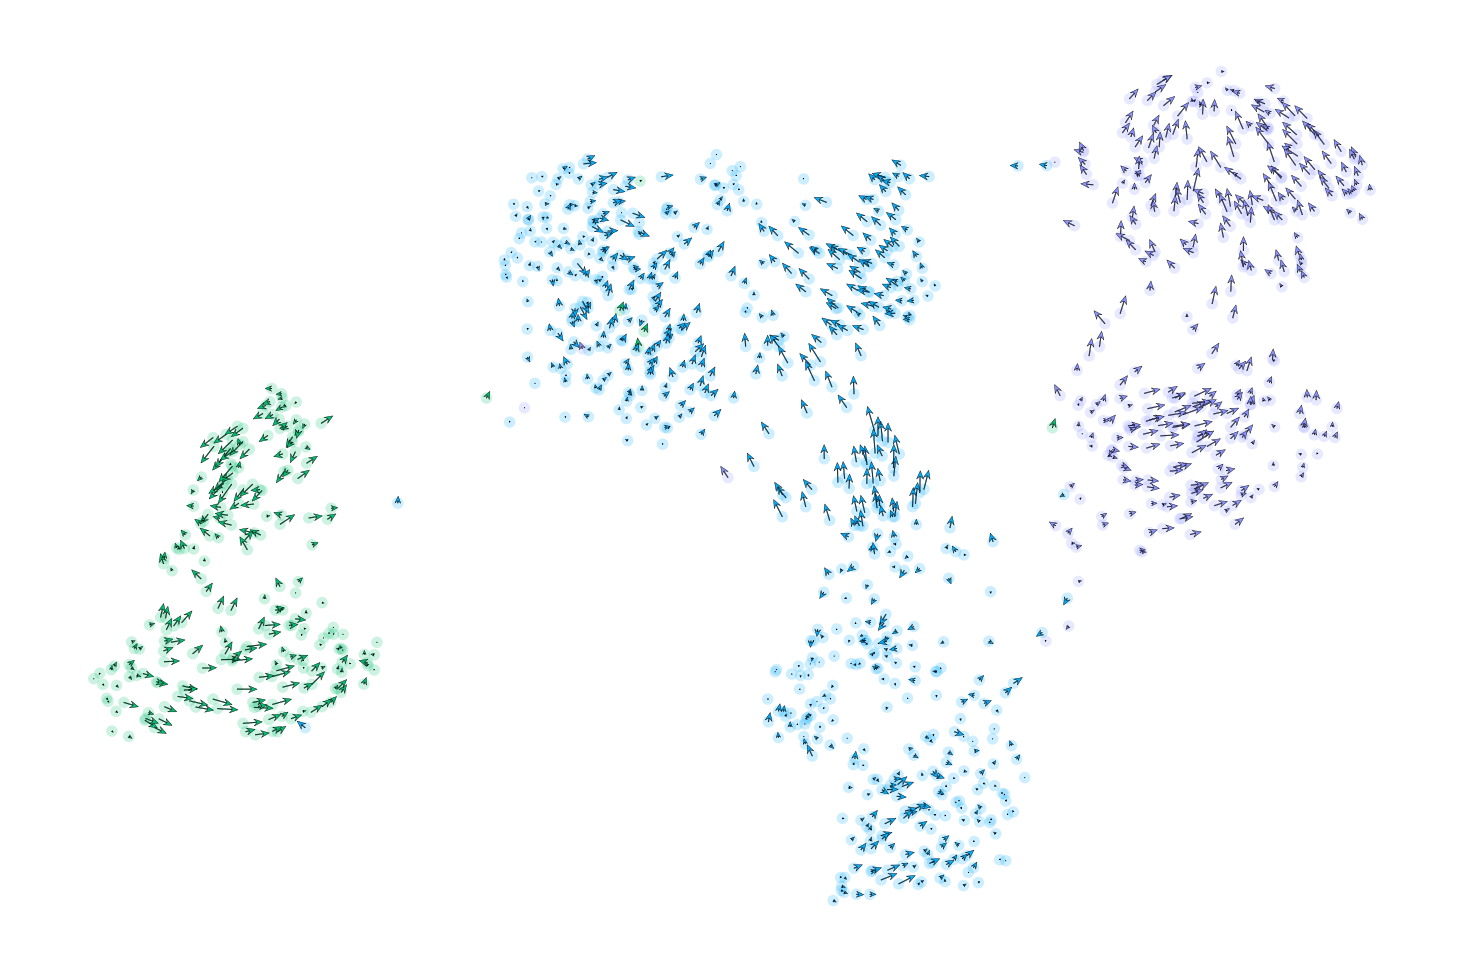

In [49]:
scv.pl.velocity_embedding(
    pou1f1_indep, 
    basis='umap', color='cell_type_brief', palette=['#00ACFC','#8B93FF','#00BE70'],
    title='', 
#     save='../figures/Fig5/pou1f1_indep_embstream.svg'
)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ../figures/Fig5/pou1f1_indep_embstream.svg


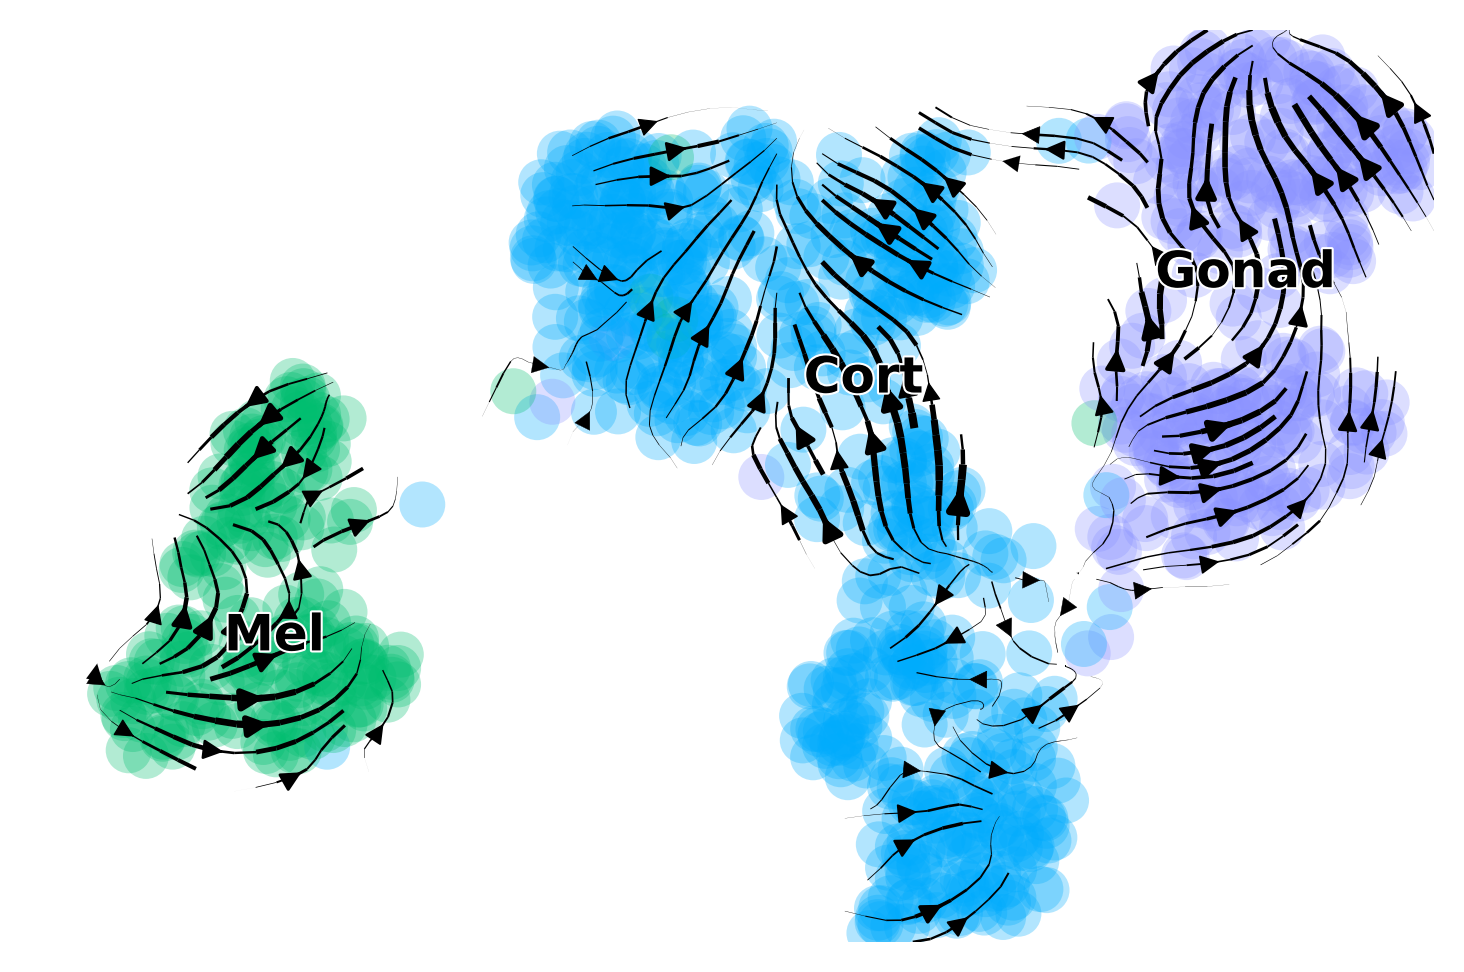

In [17]:
scv.pl.velocity_embedding_stream(
    pou1f1_indep, 
    basis='umap', color='cell_type_brief', palette=['#00ACFC','#8B93FF','#00BE70'],
    title='', save='../figures/Fig5/pou1f1_indep_embstream.svg'
)

### Speed and coherence
* Speed: length of the velocity vector
* Coherence: how well a velocity vector correlates to its neighbors

These provide insights where cells differentiate at a slower/faster pace, and where the direction is un-/determined.

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


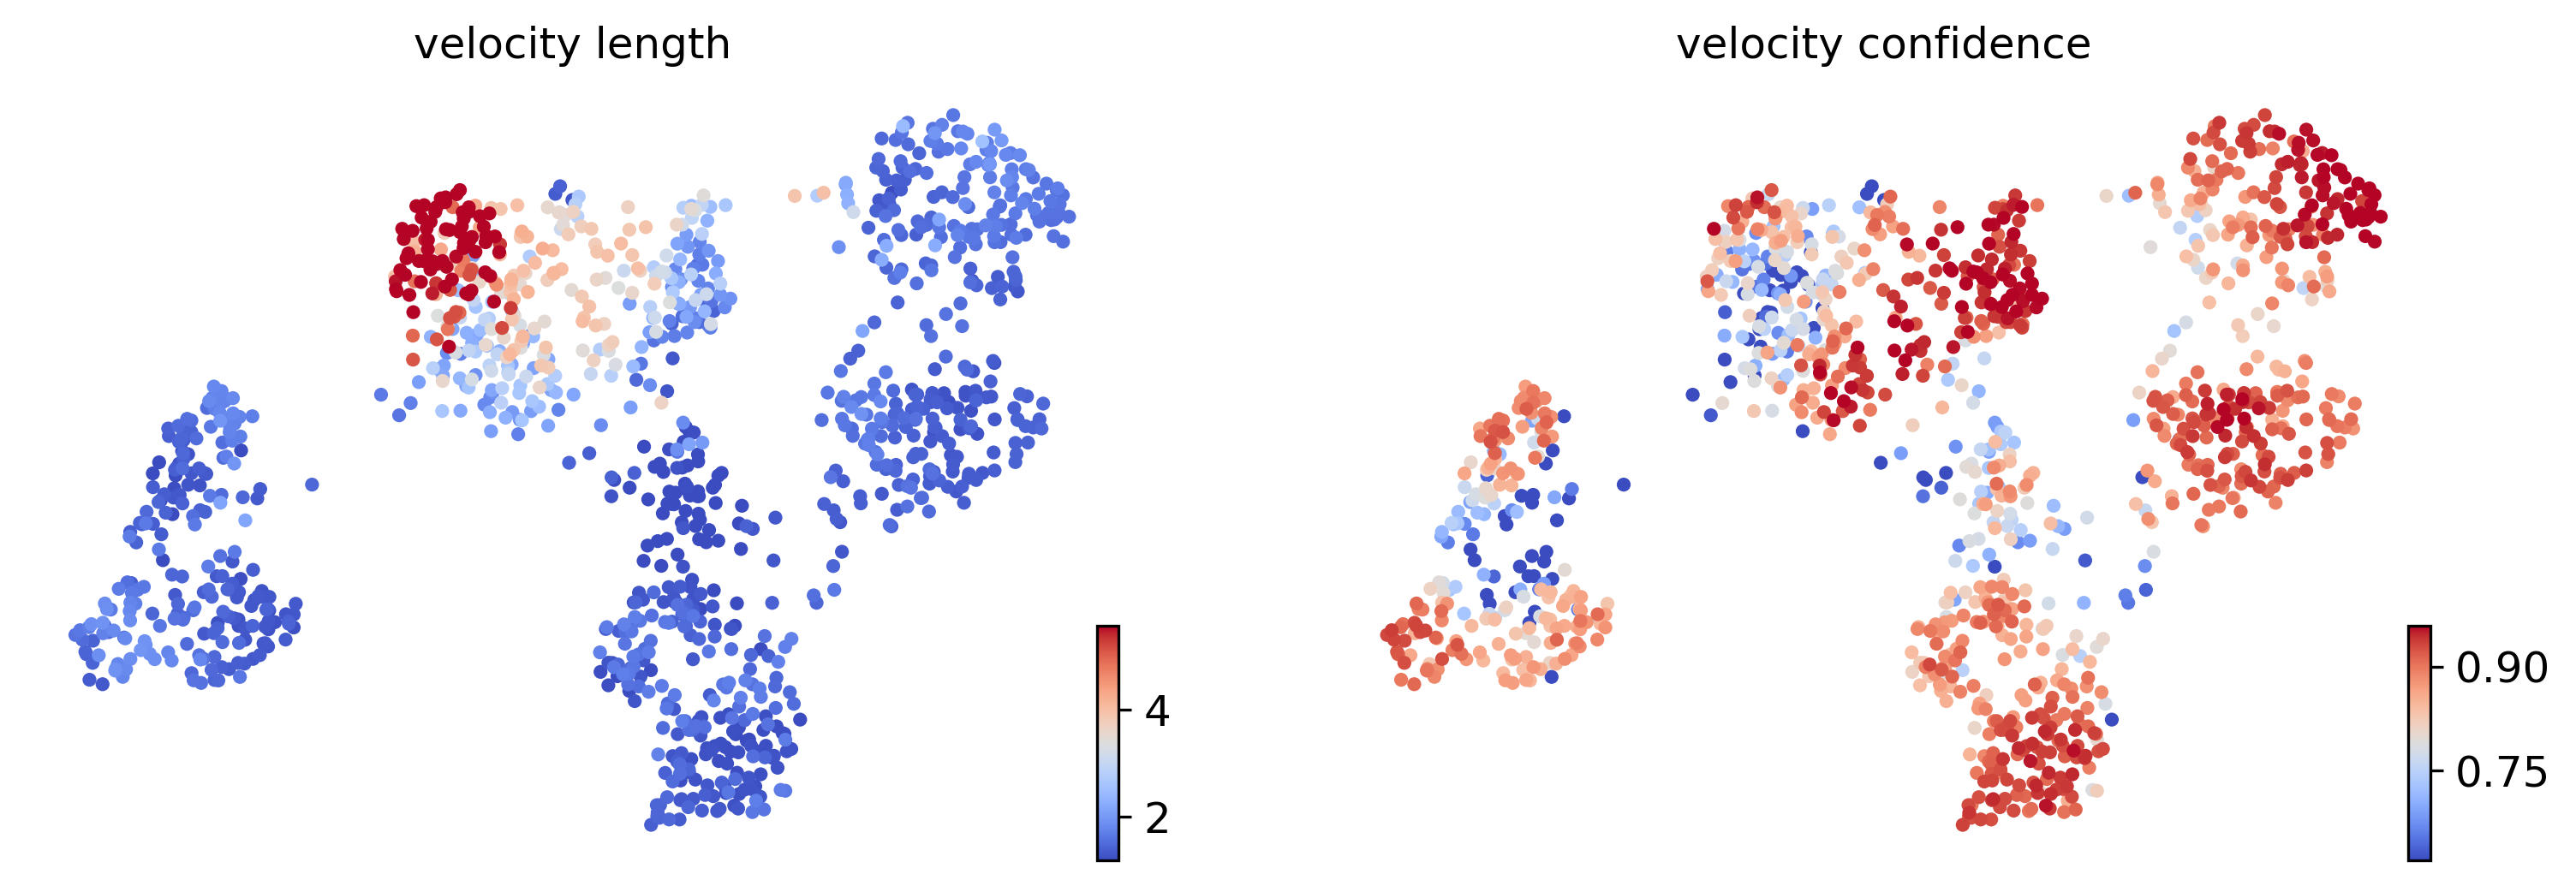

In [18]:
scv.tl.velocity_confidence(pou1f1_indep)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(pou1f1_indep, c=keys, cmap='coolwarm', perc=[5,95])

### Kinetic rate parameters

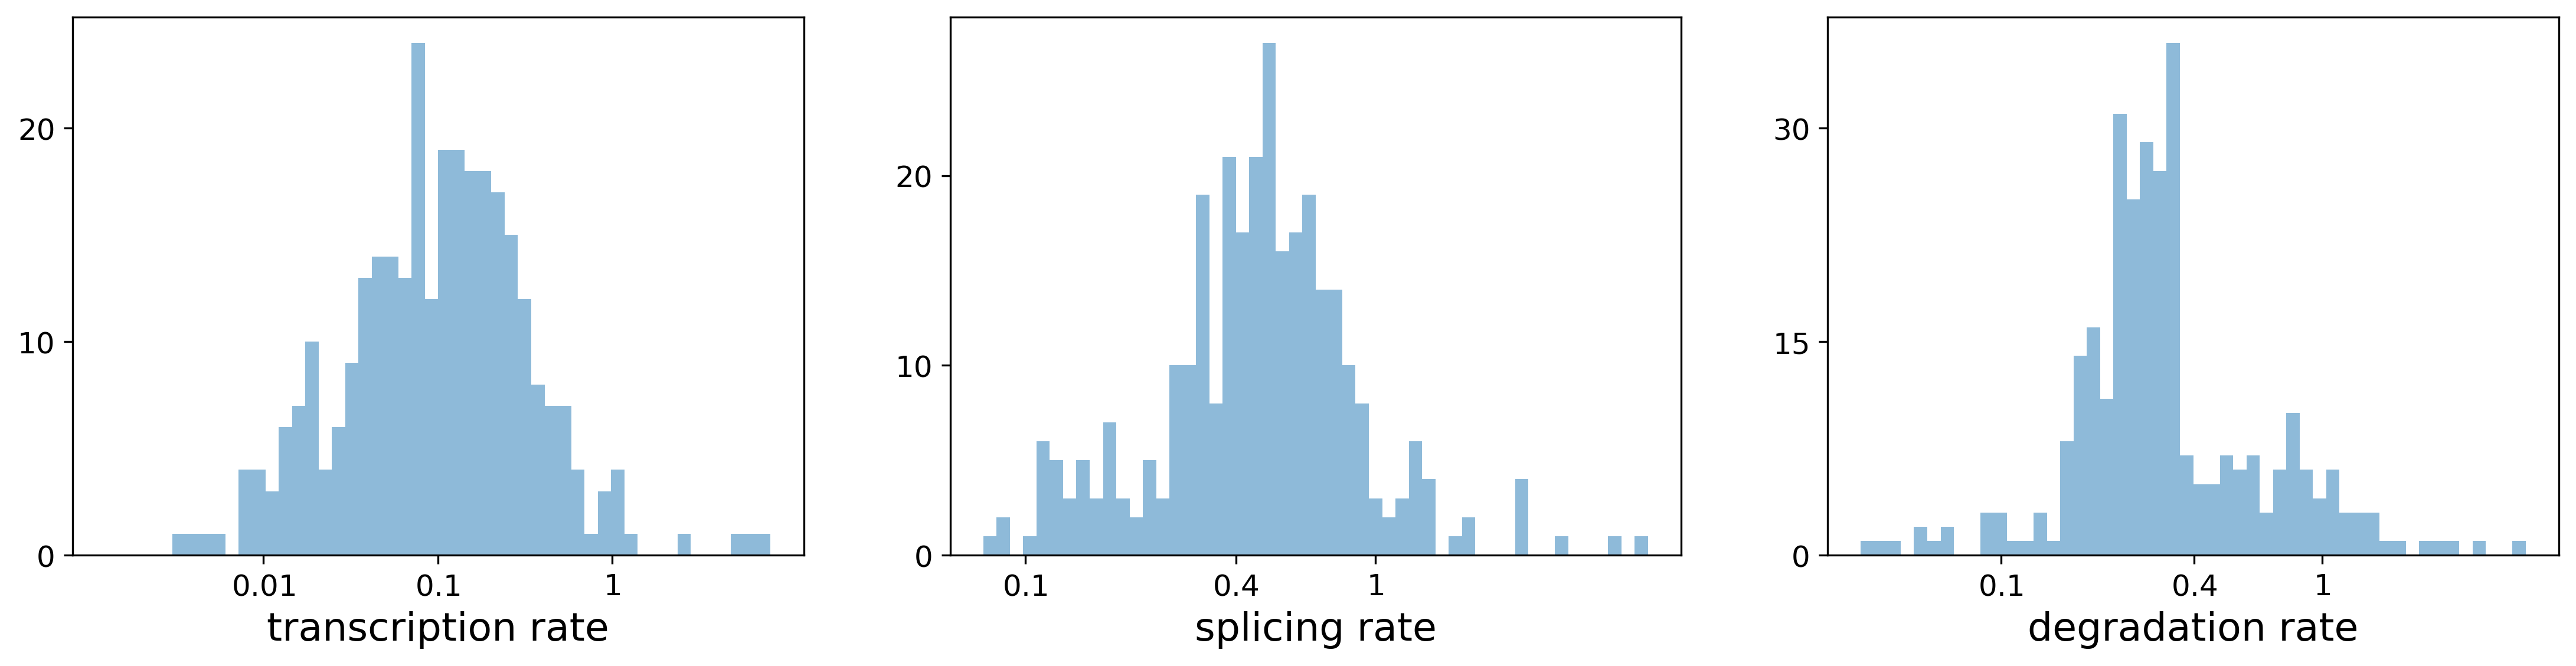

fit_r2  fit_alpha  fit_beta  fit_gamma     fit_t_  \
1110017D15Rik  0.033040   0.087088  2.295444   0.397425   8.851863   
1110038B12Rik  0.205312   0.240497  6.235246   0.509384   7.115664   
1700012C14Rik  0.076617   0.007231  1.038394   0.507617  27.216414   
1700112D23Rik  0.014370   0.009747  0.650614   0.240368  18.795835   
2610318N02Rik  0.066275   0.012625  0.581416   0.292138  26.362070   

               fit_scaling  fit_std_u  fit_std_s  fit_likelihood  fit_u0  \
1110017D15Rik     0.240533   0.011305   0.068147        0.252195     0.0   
1110038B12Rik     0.051577   0.012011   0.104795        0.185810     0.0   
1700012C14Rik     0.256891   0.001290   0.002260        0.144904     0.0   
1700112D23Rik     0.192678   0.003248   0.009272        0.023568     0.0   
2610318N02Rik     0.243505   0.004263   0.009191        0.197220     0.0   

               fit_s0  fit_pval_steady  fit_steady_u  fit_steady_s  \
1110017D15Rik     0.0     3.239887e-01      0.029316      0.146747   
1110038B12Rik     0.0     2.673561e-01      0.035915      0.286576   
1700012C14Rik     0.0     4.658812e-09      0.005810      0.010177   
1700112D23Rik     0.0     2.019189e-02      0.012103      0.026262   
2610318N02Rik     0.0     1.757165e-07      0.019995      0.034080   

               fit_variance  fit_alignment_scaling  
1110017D15Rik      0.541758               2.626194  
1110038B12Rik      0.810150               1.399276  
1700012C14Rik      0.316082               1.969992  
1700112D23Rik      0.726751               4.387391  
2610318N02Rik      0.714415               3.803991

In [19]:
df = pou1f1_indep.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(pou1f1_indep, 'fit*', dropna=True).head()

In [20]:
scv.get_df(pou1f1_indep, 'fit*', dropna=True).to_csv("../outs/scvelo/pou1f1_indep_kinetic_params.csv")

### Latent time
Omitted since it's not relevant.

### Velocity graph
We can visualize the velocity graph to potray all velocity-inferred cell-to-cell connections/transitions. It can be confined to high-probability transitions by setting a `threshold`.

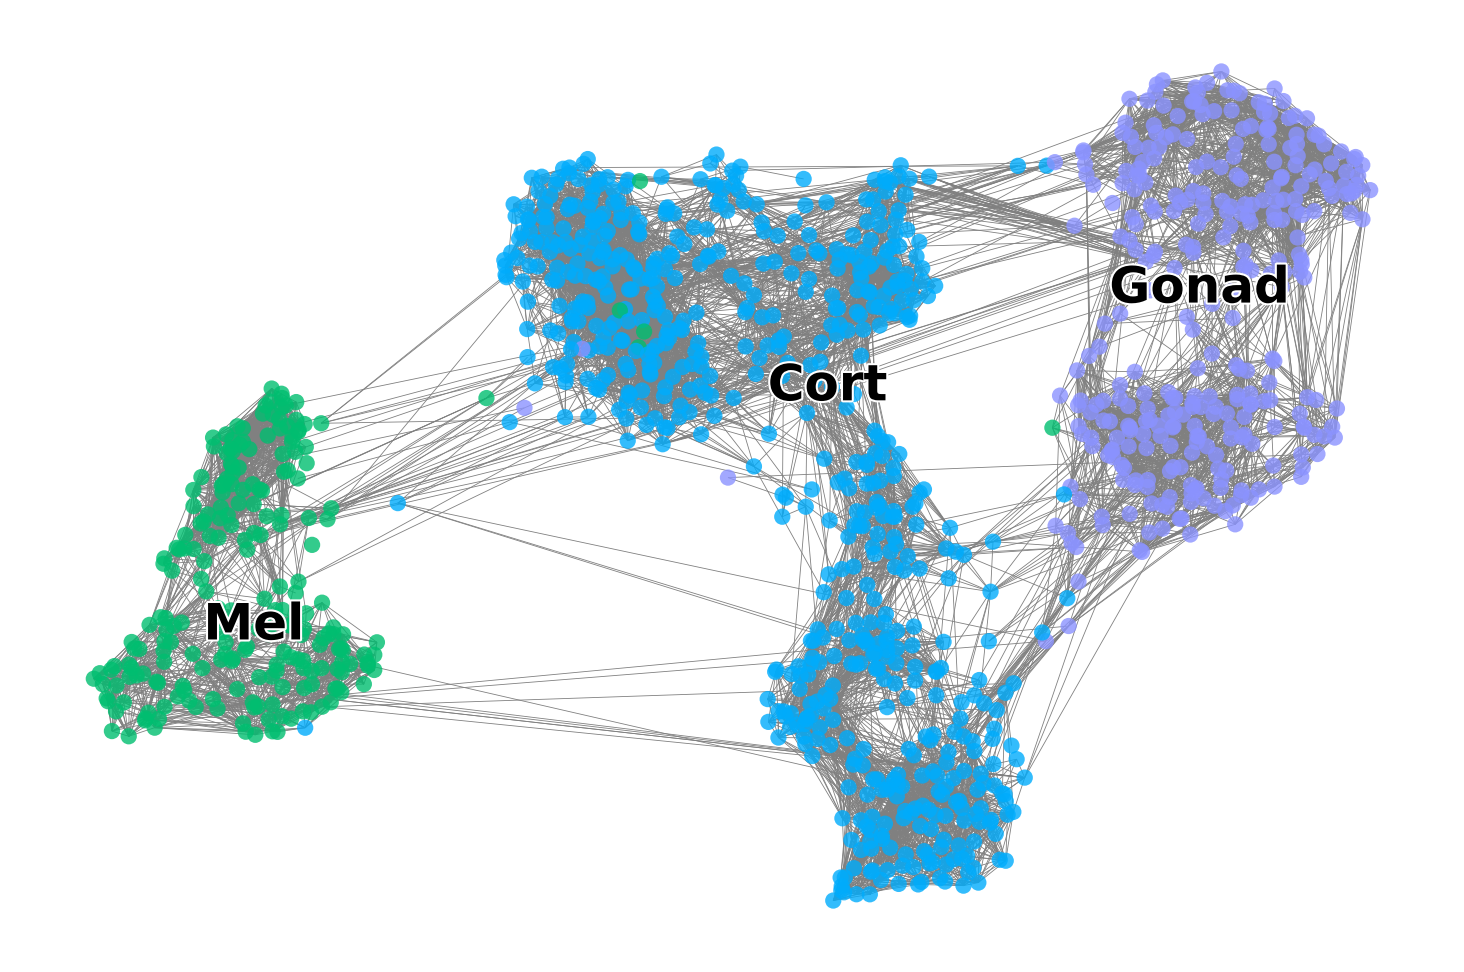

In [21]:
scv.pl.velocity_graph(pou1f1_indep, threshold=.1, color='cell_type_brief', legend_loc='on data', title='')

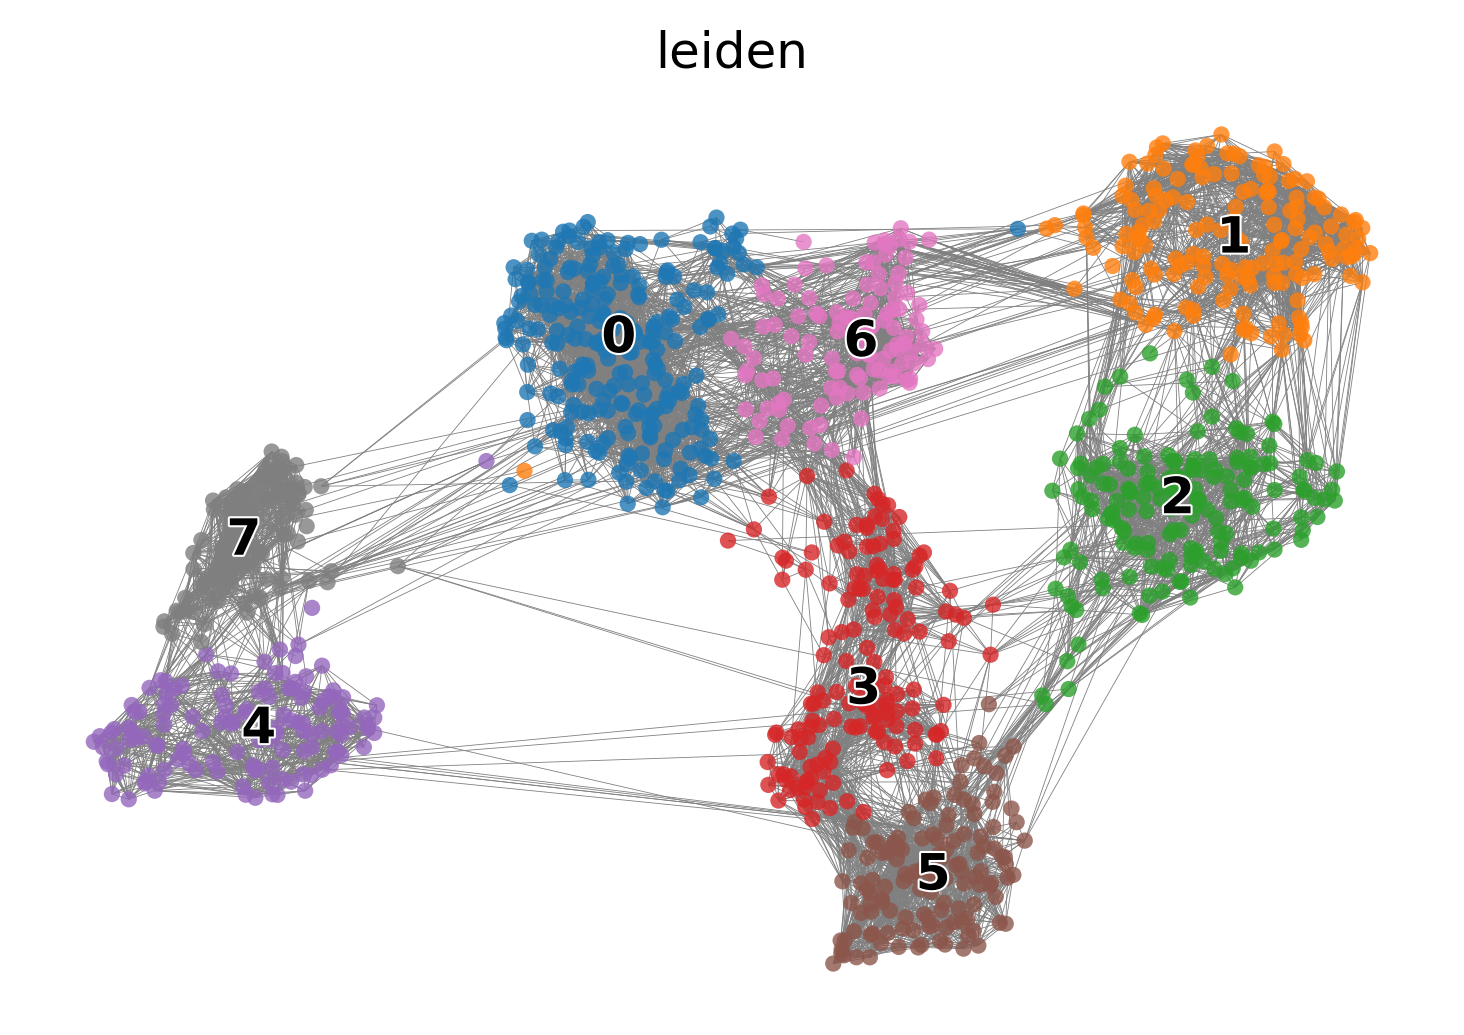

In [22]:
scv.pl.velocity_graph(pou1f1_indep, threshold=.1, color='leiden', legend_loc='on data')

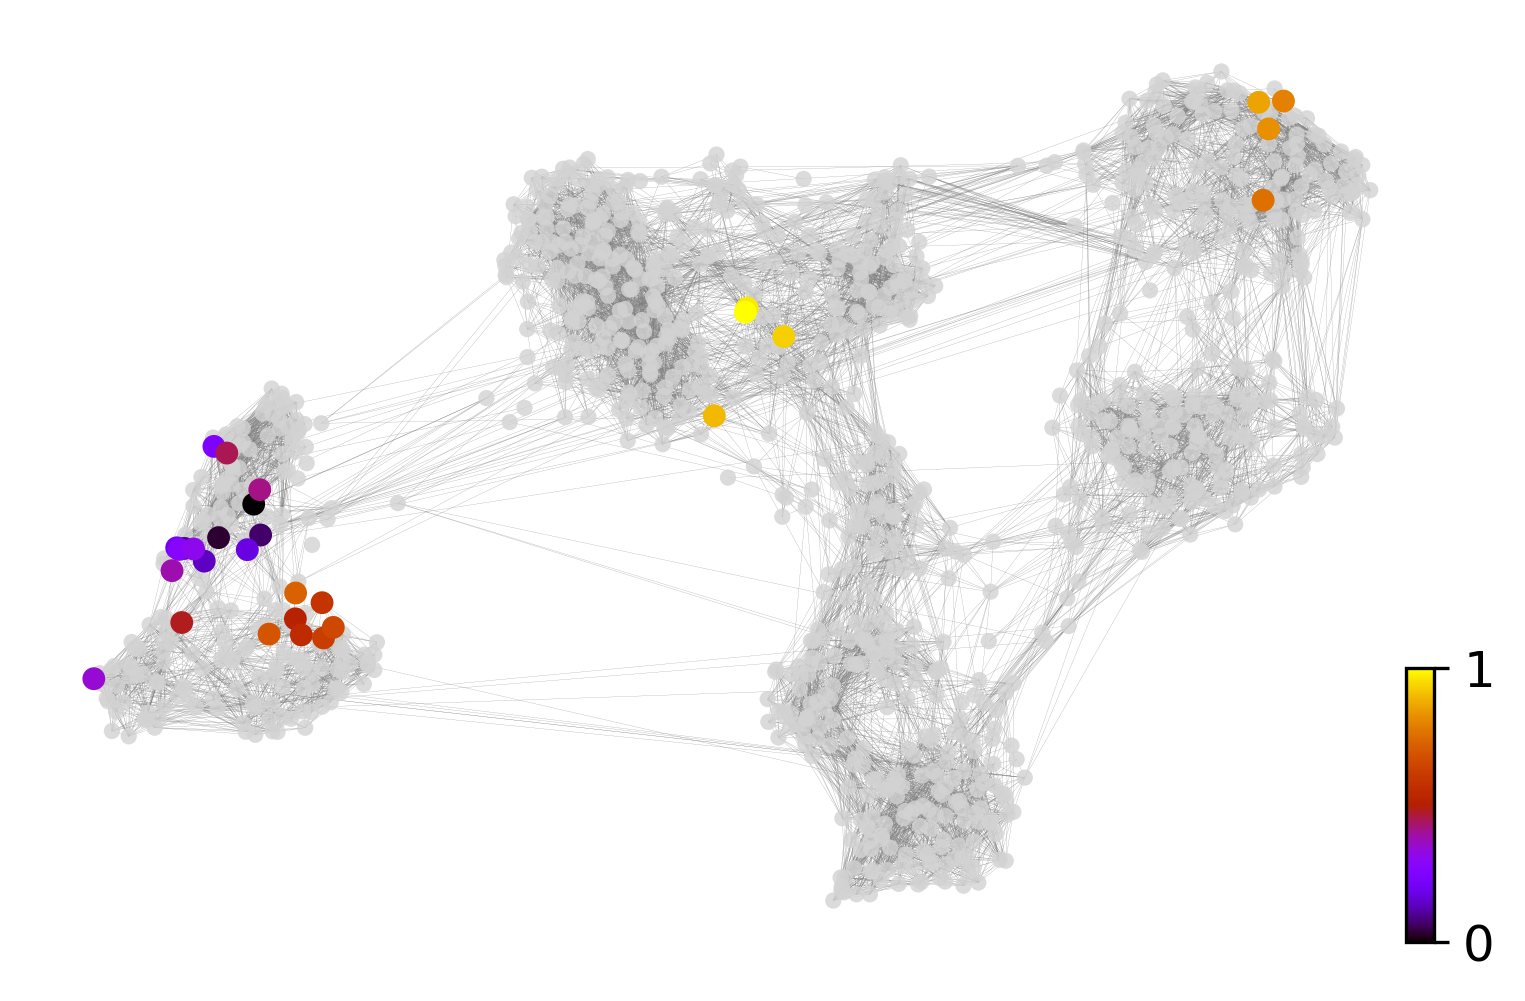

In [23]:
x, y = scv.utils.get_cell_transitions(pou1f1_indep, basis='umap', starting_cell=5)
ax = scv.pl.velocity_graph(pou1f1_indep, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(pou1f1_indep, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

computing terminal states
    identified 3 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


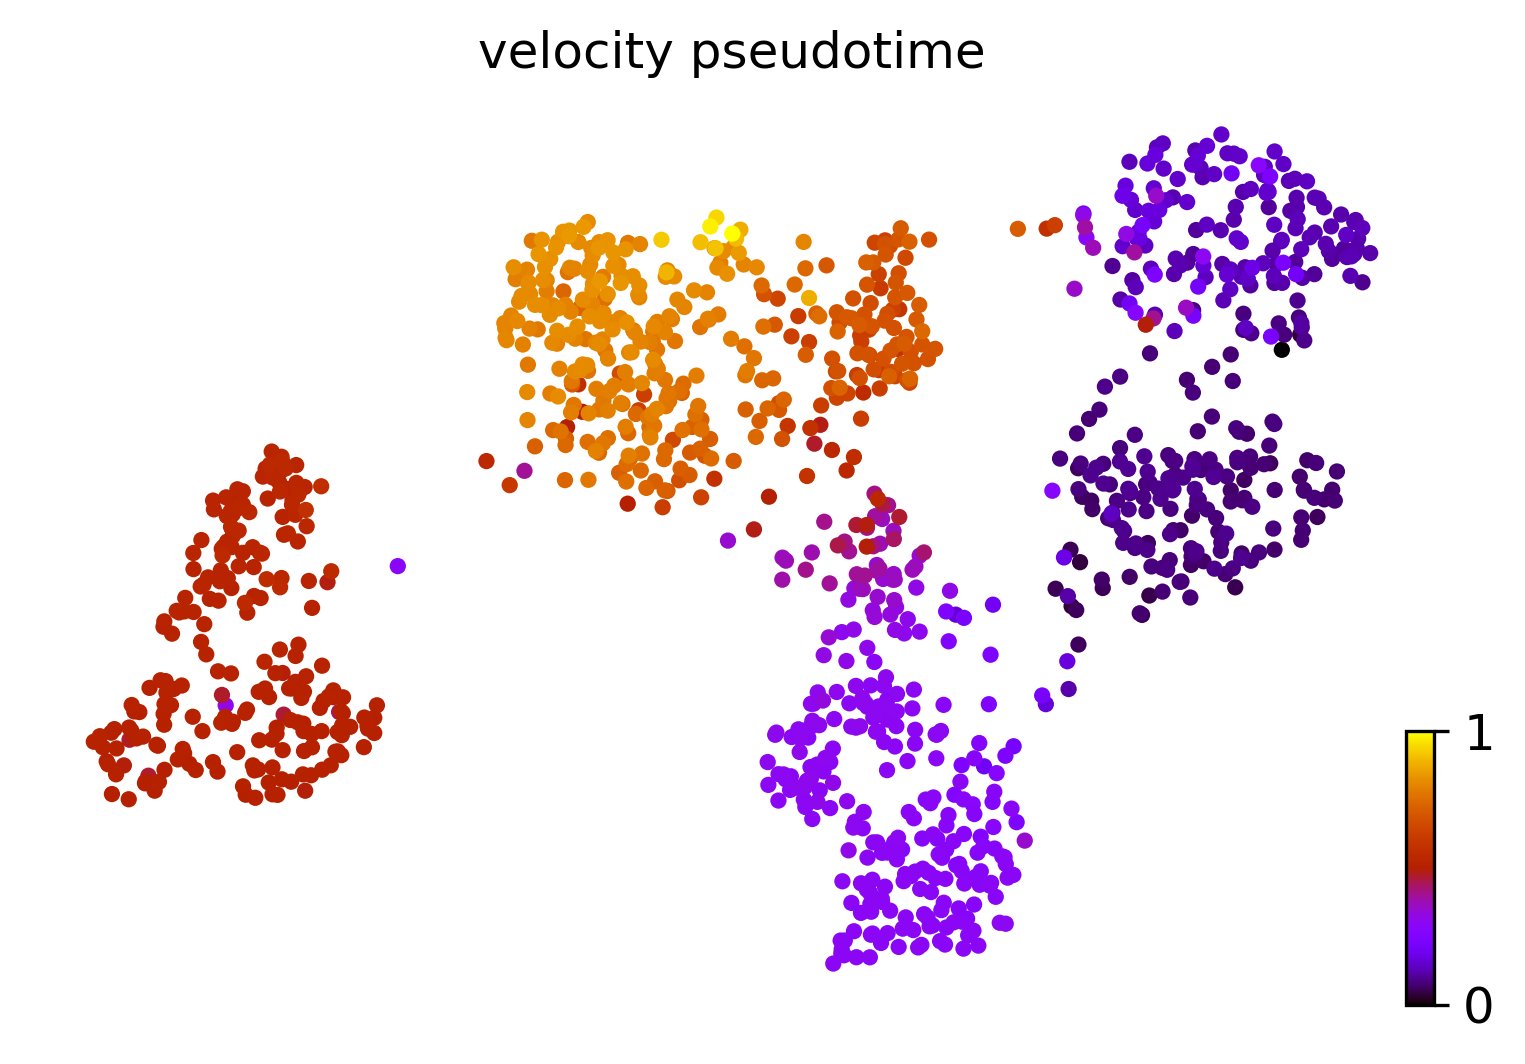

In [24]:
scv.tl.velocity_pseudotime(pou1f1_indep)
scv.pl.scatter(pou1f1_indep, color='velocity_pseudotime', cmap='gnuplot')

In [25]:
pou1f1_indep.uns['neighbors']['distances'] = pou1f1_indep.obsp['distances']
pou1f1_indep.uns['neighbors']['connectivities'] = pou1f1_indep.obsp['connectivities']

In [41]:
scv.tl.paga(pou1f1_indep, groups='leiden')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


saving figure to file ../figures/Fig5/pou1f1_indep_paga.svg


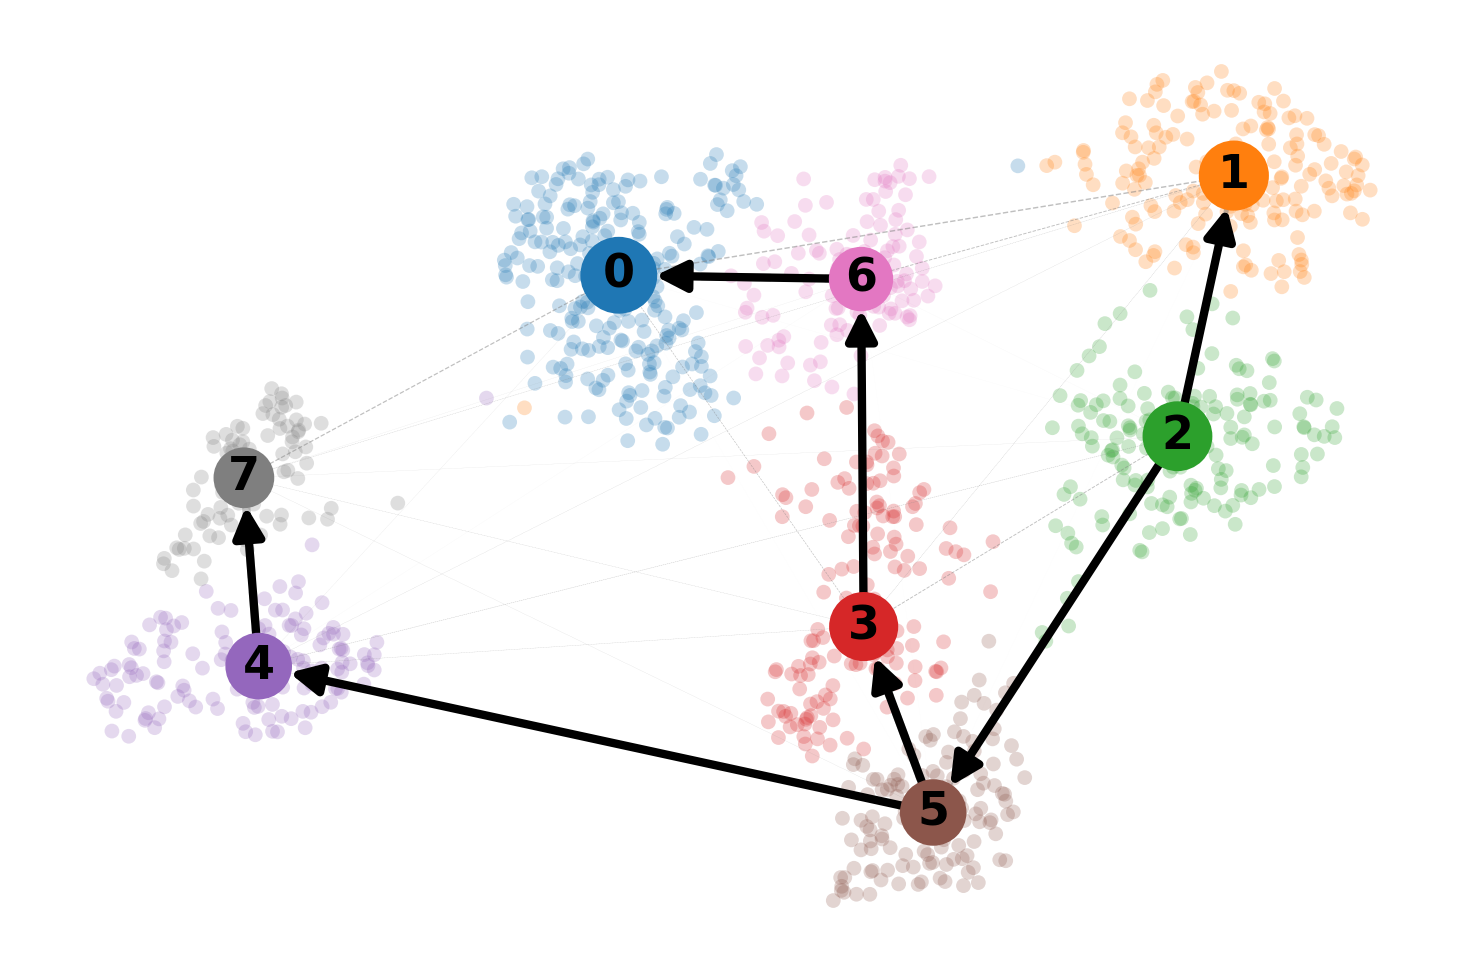

In [46]:
scv.pl.paga(pou1f1_indep, basis='umap', size=50, alpha=.25, 
            min_edge_width=2, node_size_scale=1.5,
            title='', legend_loc='on data',
            save='../figures/Fig5/pou1f1_indep_paga.svg')

### Top-likelihood genes
Driver genes display pronounced dynamic behavior and are systematically detected via their characterization by high likelihoods in the dynamic model.

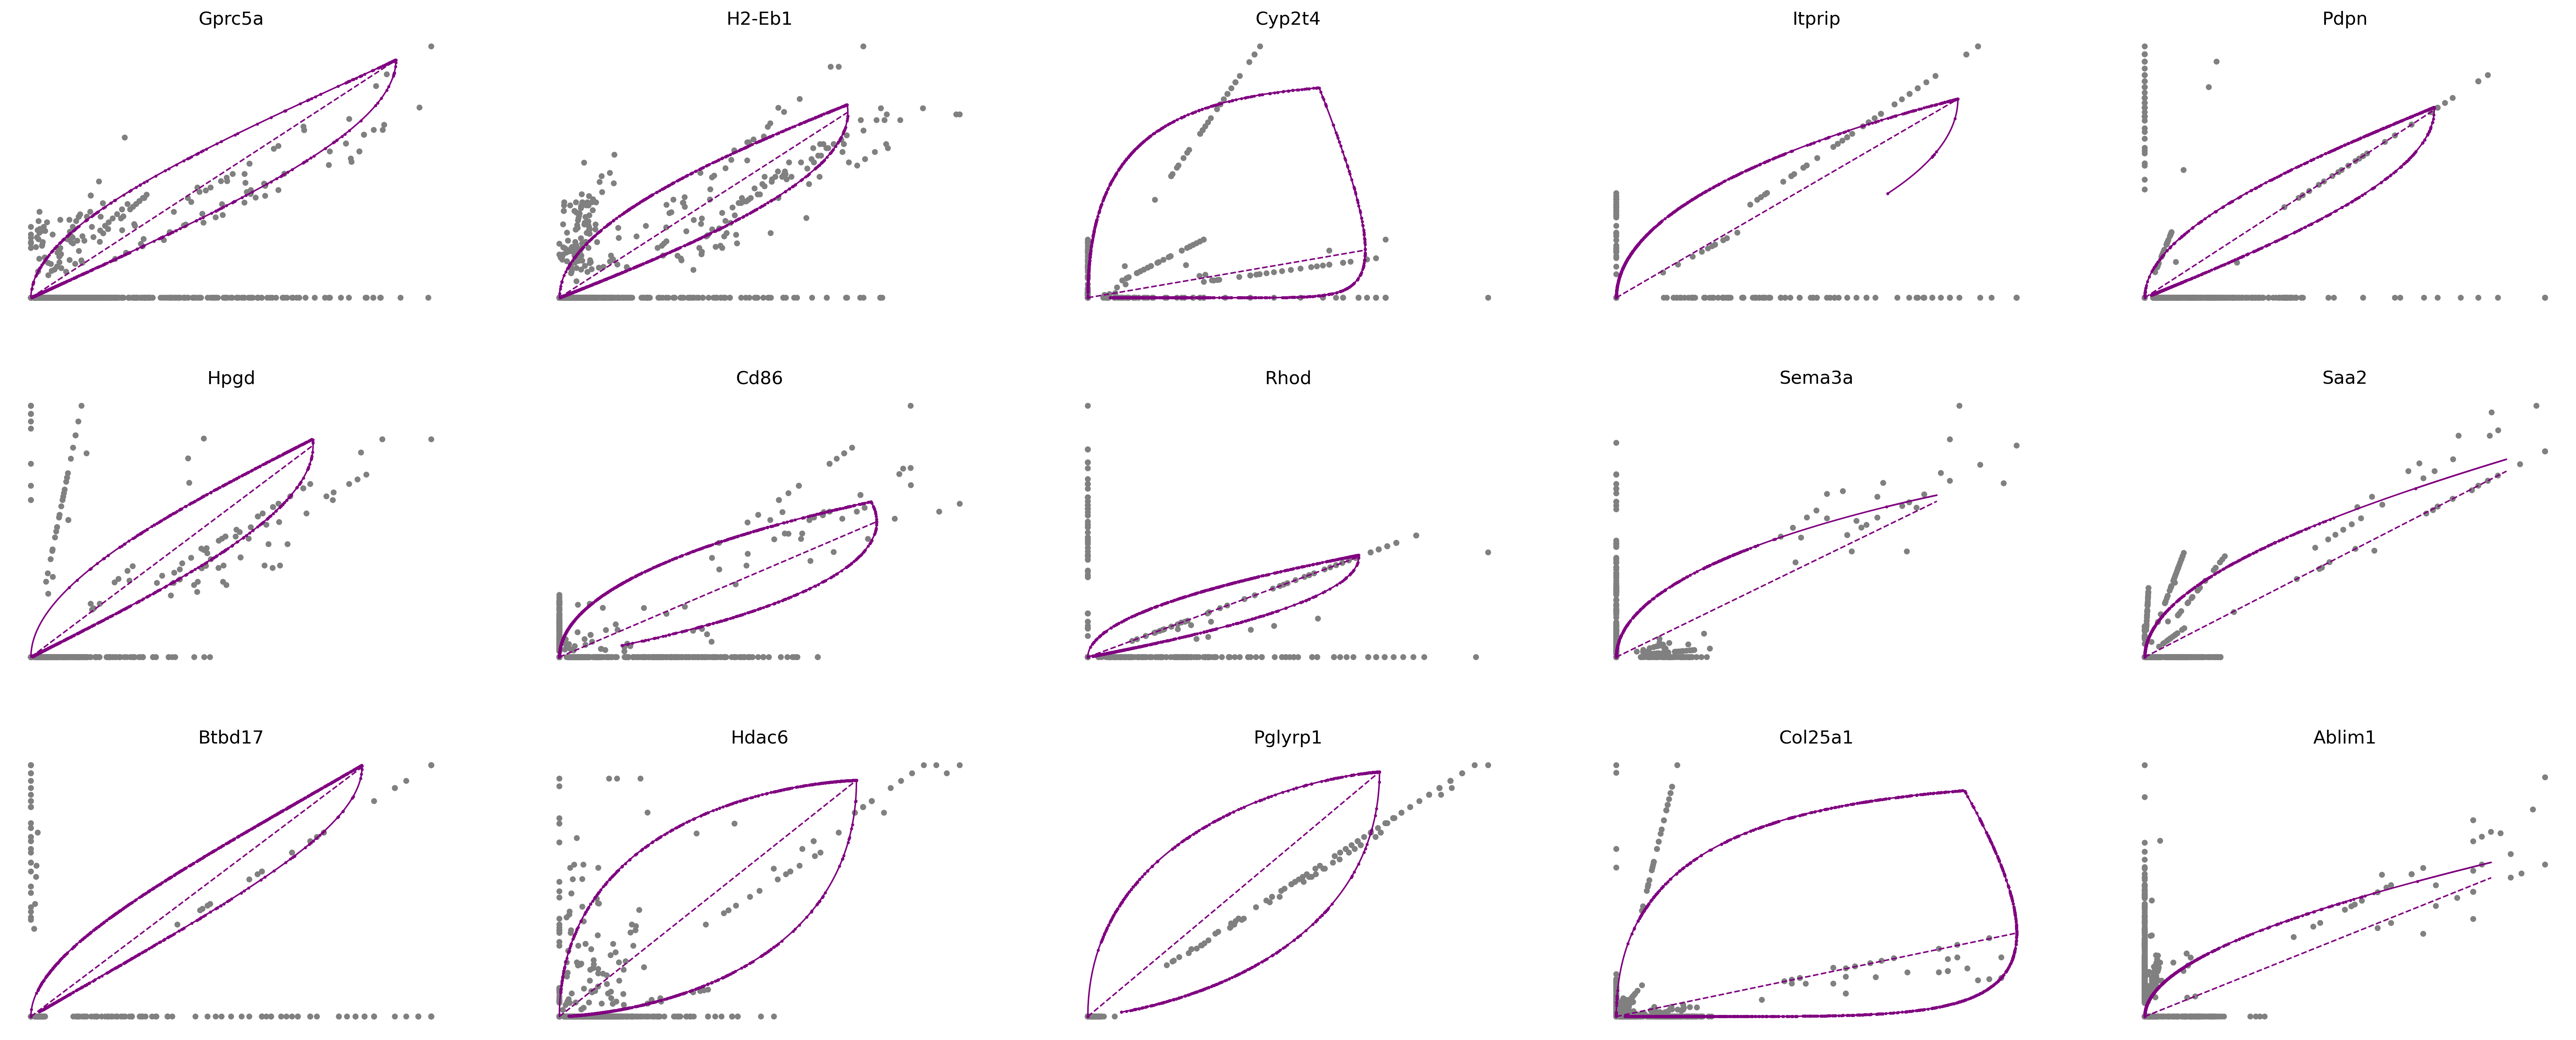

In [30]:
top_genes = pou1f1_indep.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(pou1f1_indep, basis=top_genes[:15], ncols=5, frameon=False)

Gene dynamics reveals multiple kinetic regimes across subpopulations.

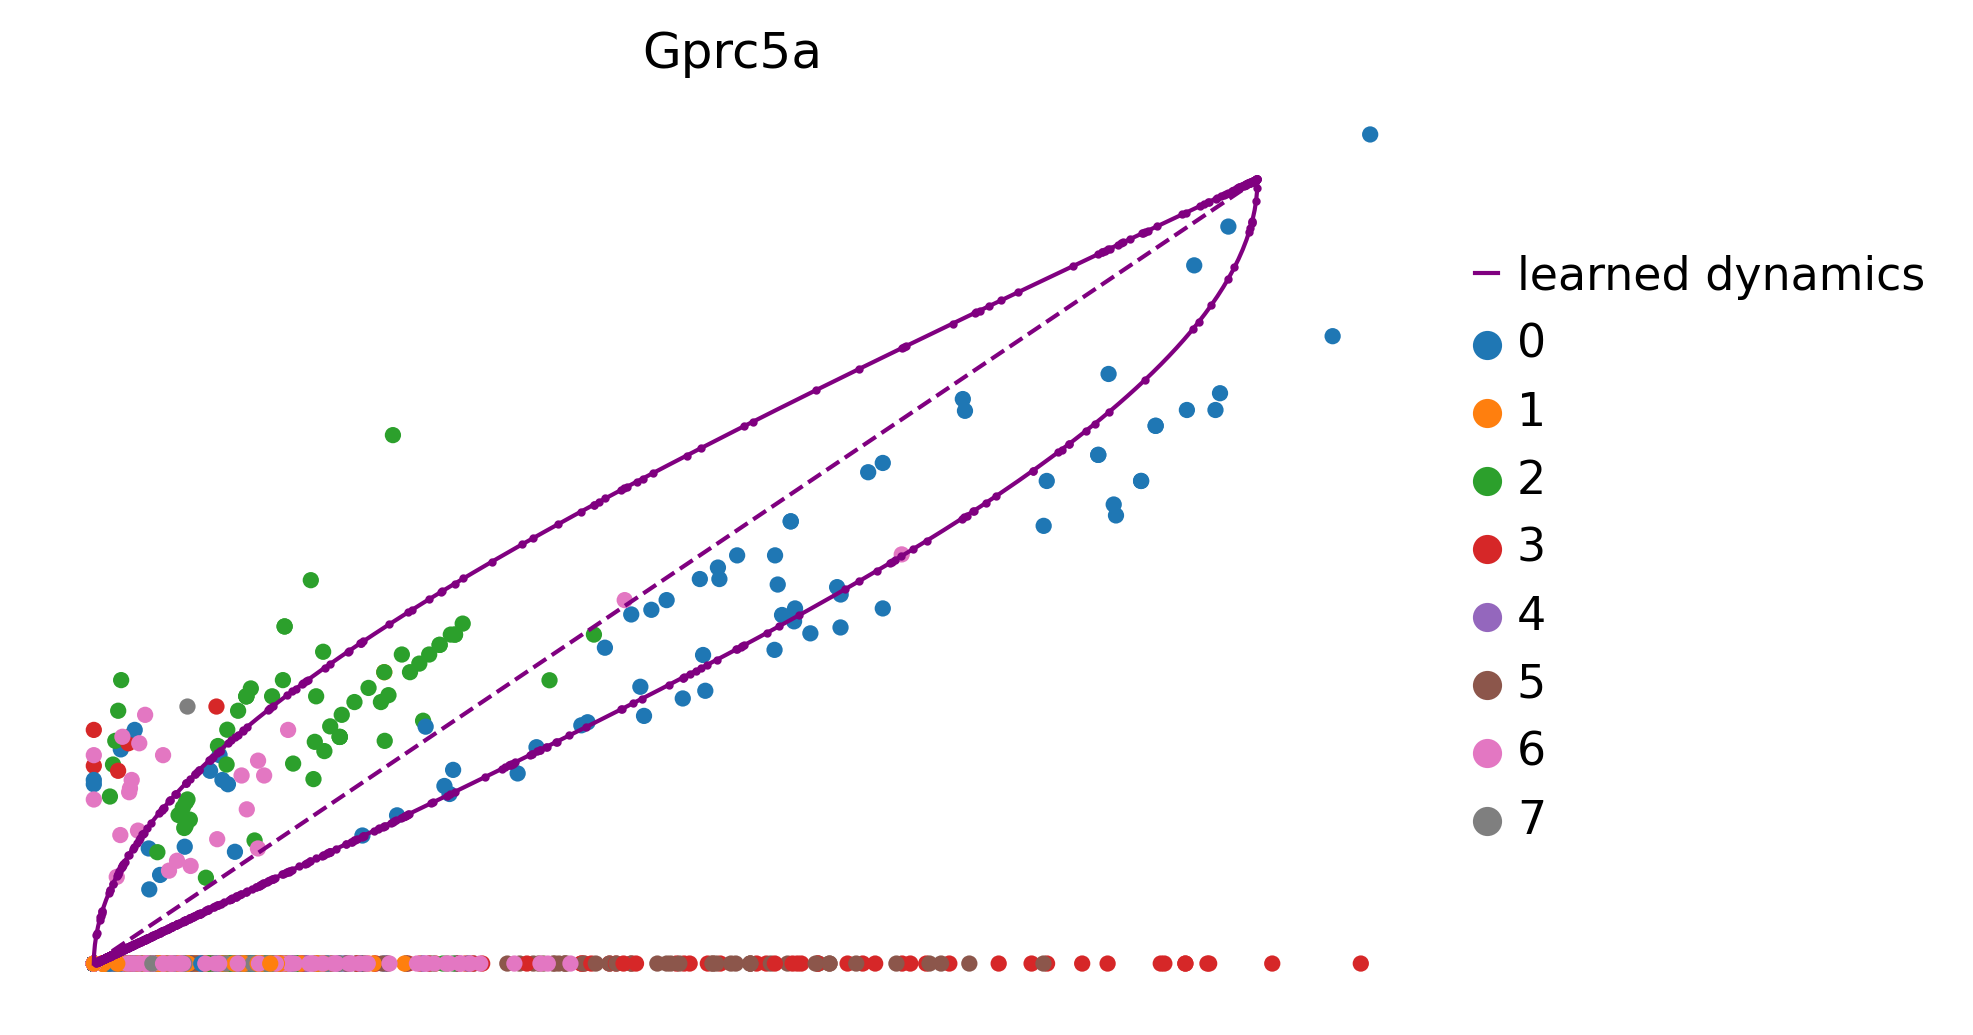

In [39]:
scv.pl.scatter(pou1f1_indep, basis=top_genes[0], color=['leiden'], legend_loc='right', frameon=False)

### Cluster-specific top-likelihood genes
Partial gene likelihoods can be computed for each cluster of cells to enable cluster-specific identification of potential drivers.

In [30]:
scv.tl.rank_dynamical_genes(pou1f1_indep, groupby='leiden')
df = scv.get_df(pou1f1_indep, 'rank_dynamical_genes/names')
df.head(5)

ranking genes by cluster-specific likelihoods
    finished (0:00:00) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


0       1              2        3        4         5  \
0         Gprc5a  Adgrg2           Rhod     Hpgd     Pdpn    H2-Eb1   
1           Camp  Itprip  1110038B12Rik  Gm12250   Gm9925   Gm40477   
2  4930502E09Rik   Cenpf         Akr1cl    Mgst2  Cd164l2     Nupr1   
3        Pglyrp1  Steap4           Chgb    Chrne     Cd86     Ptpre   
4         Samd9l  Gtpbp1           Pkib    Anxa2   Ablim1  Ppp1r14a   

               6        7  
0           Saa2   Btbd17  
1         Itga2b  Rps6kb2  
2          Ttll8  Gm40477  
3  A930016O22Rik      Dcn  
4          Syce2    Gria3